In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image, ImageDraw
from torchvision.transforms.functional import pil_to_tensor


def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    """
    Rescale and display an image represented as a tensor or PIL Image.
    The function scales the img to the [0, 1] range.
    The img is assumed to have shape 3xHxW (RGB) or 1xHxW (grayscale).

    Args:
        img (torch.Tensor or PIL.Image): image.
        quiet (bool, optional): if False, display image. Default: False.
        lim (list, optional): [min, max] for rescaling. Default: None.
        interpolation (str, optional): Interpolation mode for imshow. Default: 'lanczos'.

    Returns:
        numpy.ndarray: Rescaled image as numpy array.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img).float()
    handle = None
    with torch.no_grad():
        if lim is None:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            # Ensure 3 channels for display
            if img.shape[0] == 1:
                img = img.expand(3, *img.shape[1:])
            bitmap = img.permute(1, 2, 0).cpu().numpy()
            return bitmap
        else:
            return img

/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/UiT/NORA_MML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
coco_images = torch.load('data/example_images_coco.pth', map_location=torch.device('mps'))

In [ ]:
processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny")

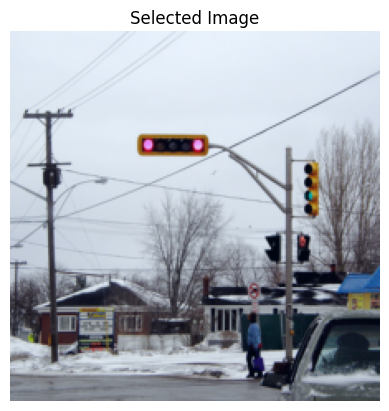

In [ ]:
image_tensor = coco_images[0]

image = imsc(image_tensor)

# Display the selected image (optional)
plt.imshow(image)
plt.axis('off')
plt.title("Selected Image")
plt.show()

In [ ]:
text_prompts = "traffic light ." # Example prompts
image_tensor = coco_images[0]  # Use the first image from the dataset

if image_tensor.shape[0] == 3:
    image_tensor = image_tensor.permute(1, 2, 0)

image_np = image_tensor.cpu().numpy()
image = (image_np - image_np.min()) / (image_np.max() - image_np.min())
image = Image.fromarray((image * 255).astype(np.uint8))

inputs = processor(images=image, text=text_prompts, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)


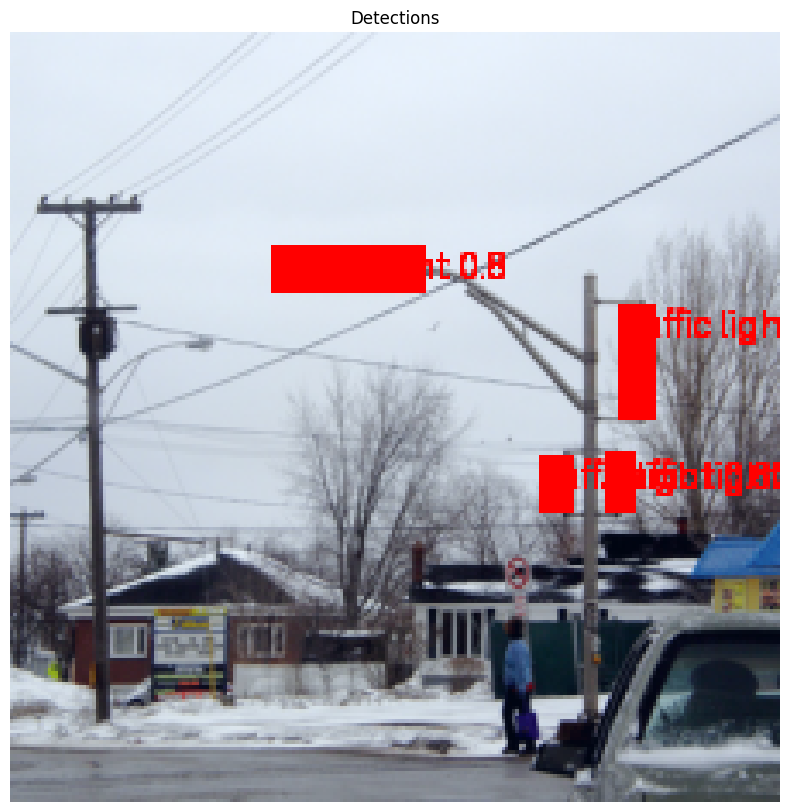

Detected objects: ['traffic light', 'traffic light', 'traffic light', 'traffic light']
Scores: tensor([0.8072, 0.7999, 0.6184, 0.6409])
Boxes: tensor([[177.6391,  79.0139, 187.3136, 112.9187],
        [ 76.9831,  62.1338, 120.3321,  75.9059],
        [154.1163, 123.2108, 163.9573, 139.6103],
        [173.8497, 122.9076, 181.8679, 139.5422]])


In [ ]:
# Post-process the outputs
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4, # Lower this threshold to detect more objects
    text_threshold=0.3, # Lower this threshold for text association
    target_sizes=[image.size[::-1]]  # (height, width)
)[0] # Get results for the first image

# Draw bounding boxes
draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    draw.rectangle(box, outline="red", width=3)
    draw.text((box[0], box[1]), f"{label}: {round(score.item(), 2)}", fill="red")

# Display the image with detections
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.title("Detections")
plt.show()

print(f"Detected objects: {results['labels']}")
print(f"Scores: {results['scores']}")
print(f"Boxes: {results['boxes']}")